Generating 5000 samples for 50 equipment units...
Generated dataset with shape: (5000, 15)
Failure rate: 2.12%
Data saved to data/maintenance_data.csv


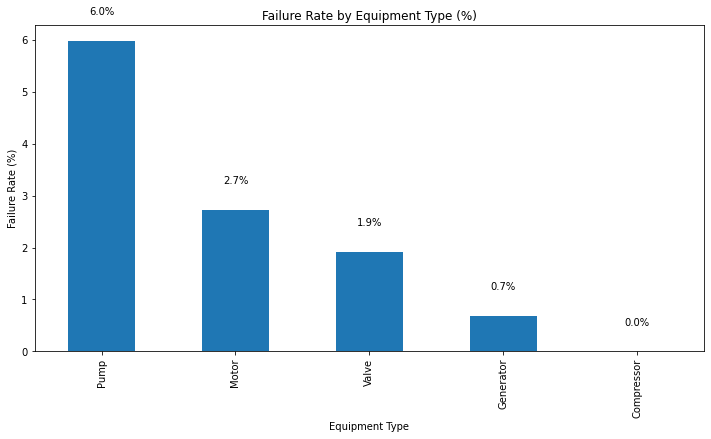

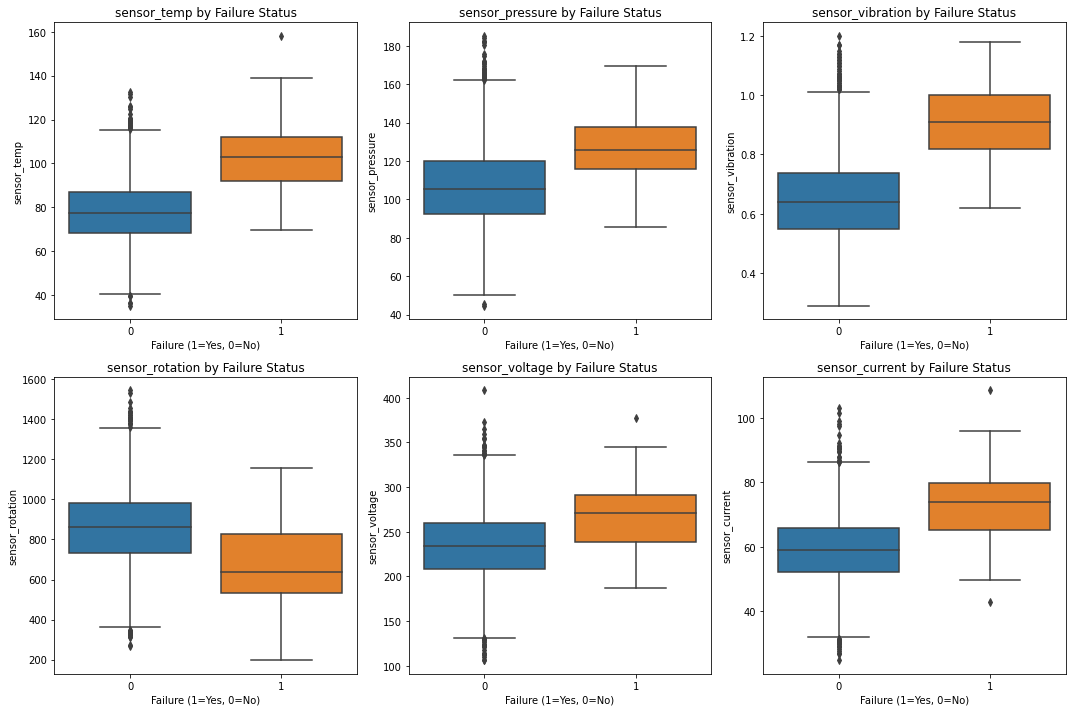

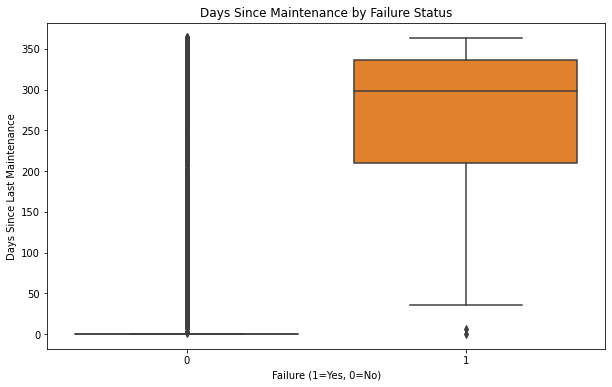

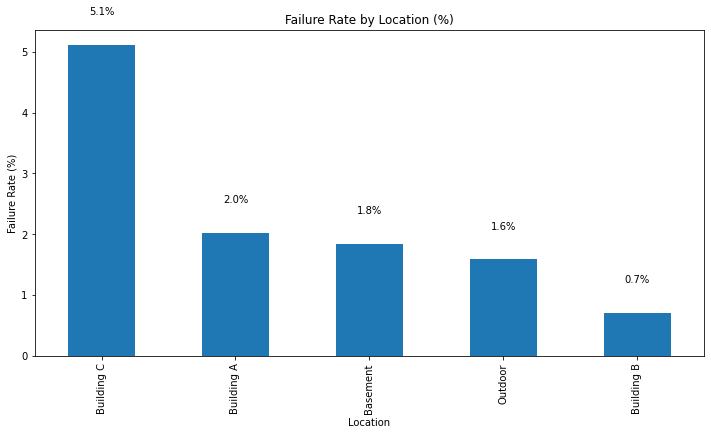

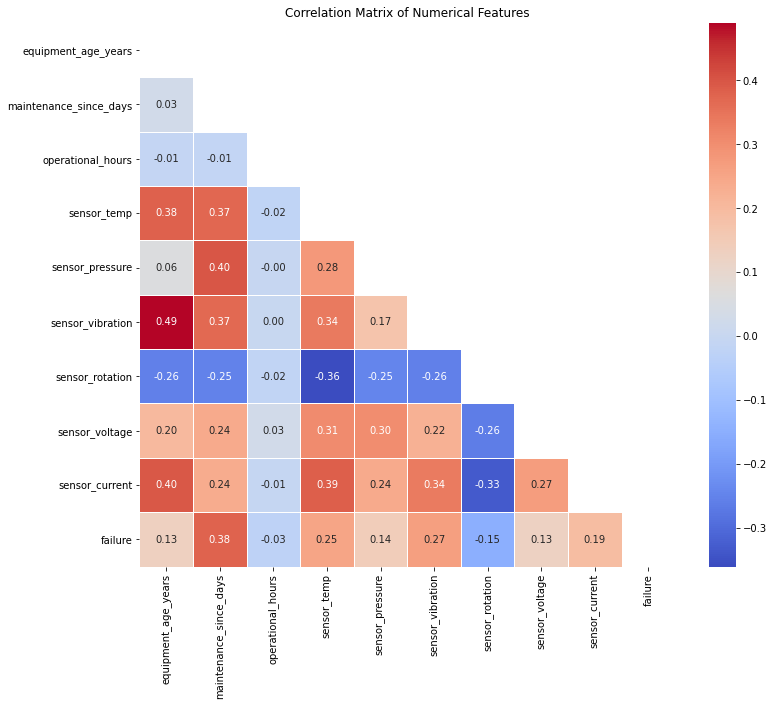

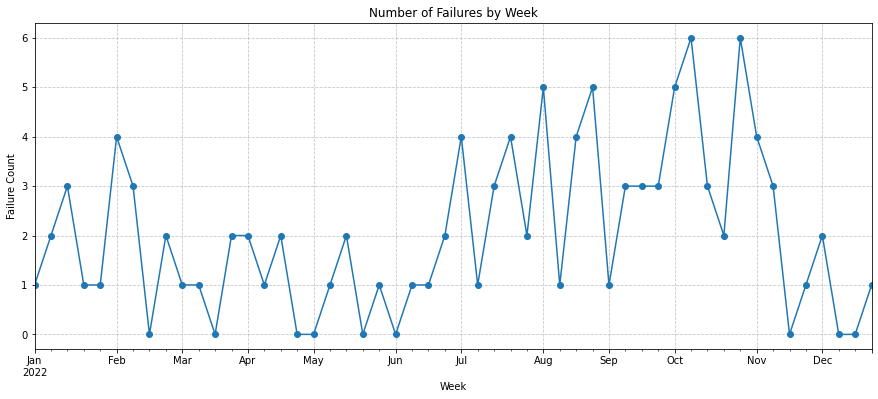

In [5]:
"""
Synthetic Data Generator for Predictive Maintenance

This script generates realistic synthetic data for testing and developing 
predictive maintenance models for industrial equipment.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import argparse

def generate_synthetic_data(n_samples=5000, n_equipment=50, start_date='2022-01-01', 
                           end_date='2023-01-01', failure_threshold=0.7, 
                           sensor_noise=0.15, add_trends=True, save_path=None):
    """
    Generate synthetic data for predictive maintenance example.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_equipment : int
        Number of unique equipment IDs
    start_date : str
        Start date for data generation
    end_date : str
        End date for data generation
    failure_threshold : float
        Threshold above which a failure is registered
    sensor_noise : float
        Amount of noise to add to sensor readings
    add_trends : bool
        Whether to add time-based trends to the data
    save_path : str
        Path to save the generated data (if None, data is not saved)
        
    Returns:
    --------
    pandas.DataFrame
        Synthetic dataset
    """
    print(f"Generating {n_samples} samples for {n_equipment} equipment units...")
    
    # Generate equipment IDs
    equipment_ids = [f"EQ{i:03d}" for i in range(1, n_equipment + 1)]
    
    # Generate timestamps
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    date_range = (end - start).days
    
    # Initialize data dictionary
    data = {
        'timestamp': pd.date_range(start=start, end=end, periods=n_samples),
        'equipment_id': np.random.choice(equipment_ids, n_samples),
    }
    
    # Assign equipment properties - these remain constant for each equipment ID
    equipment_properties = {}
    for eq_id in equipment_ids:
        equipment_properties[eq_id] = {
            'base_temp': np.random.uniform(60, 70),
            'base_pressure': np.random.uniform(90, 110),
            'base_vibration': np.random.uniform(0.4, 0.6),
            'base_rotation': np.random.uniform(900, 1100),
            'base_voltage': np.random.uniform(210, 230),
            'base_current': np.random.uniform(45, 55),
            'equipment_age_years': np.random.uniform(0, 10),
            'quality_factor': np.random.uniform(0.8, 1.0),  # Higher means better quality
            'maintenance_frequency': np.random.choice([30, 60, 90, 120, 180, 365])  # Days between maintenance
        }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Sort by timestamp and equipment_id
    df = df.sort_values(['timestamp', 'equipment_id']).reset_index(drop=True)
    
    # Add equipment properties
    df['equipment_age_years'] = df['equipment_id'].map(lambda x: equipment_properties[x]['equipment_age_years'])
    
    # Add equipment type
    equipment_types = ['Pump', 'Motor', 'Valve', 'Compressor', 'Generator']
    equipment_type_map = {eq_id: np.random.choice(equipment_types) for eq_id in equipment_ids}
    df['equipment_type'] = df['equipment_id'].map(equipment_type_map)
    
    # Add location
    locations = ['Building A', 'Building B', 'Building C', 'Outdoor', 'Basement']
    location_map = {eq_id: np.random.choice(locations) for eq_id in equipment_ids}
    df['location'] = df['equipment_id'].map(location_map)
    
    # Create a mapping of the last maintenance date for each equipment
    last_maintenance = {eq_id: start - timedelta(days=np.random.randint(0, equipment_properties[eq_id]['maintenance_frequency'])) 
                       for eq_id in equipment_ids}
    
    # Calculate days since last maintenance for each row
    df['maintenance_since_days'] = df.apply(
        lambda row: (row['timestamp'] - last_maintenance[row['equipment_id']]).days, axis=1
    )
    
    # Update last maintenance date when maintenance_since_days exceeds maintenance_frequency
    for i, row in df.iterrows():
        eq_id = row['equipment_id']
        maintenance_frequency = equipment_properties[eq_id]['maintenance_frequency']
        if row['maintenance_since_days'] >= maintenance_frequency:
            # Perform maintenance
            last_maintenance[eq_id] = row['timestamp']
            df.at[i, 'maintenance_since_days'] = 0
    
    # Add operational hours (more likely during weekdays and working hours)
    df['is_weekday'] = df['timestamp'].dt.dayofweek < 5  # Monday-Friday
    df['is_workhour'] = df['timestamp'].dt.hour.between(8, 18)  # 8 AM - 6 PM
    
    # Higher operational hours during weekdays and work hours
    df['operational_hours'] = np.where(df['is_weekday'] & df['is_workhour'],
                                      np.random.uniform(6, 10, n_samples),
                                      np.random.uniform(0, 6, n_samples))
    
    # Drop temporary columns
    df = df.drop(['is_weekday', 'is_workhour'], axis=1)
    
    # Add weather condition
    weather_conditions = ['Normal', 'Hot', 'Cold', 'Humid', 'Dry']
    # Weather changes over time
    weather_periods = pd.date_range(start=start, end=end, freq='7D')
    weather_mapping = {}
    
    for i in range(len(weather_periods) - 1):
        weather_mapping[(weather_periods[i], weather_periods[i+1])] = np.random.choice(weather_conditions)
    
    # Add handling for dates that might be outside the defined periods
    def get_weather(ts):
        for (s, e), v in weather_mapping.items():
            if s <= ts < e:
                return v
        # Fallback - return "Normal" for any date outside defined periods
        return "Normal"
    
    df['weather_condition'] = df['timestamp'].apply(get_weather)
    
    # Generate base sensor readings
    for eq_id in equipment_ids:
        # Filter rows for this equipment
        mask = df['equipment_id'] == eq_id
        n_eq_samples = mask.sum()
        
        # Get equipment properties
        props = equipment_properties[eq_id]
        quality = props['quality_factor']  # Higher quality means more stable readings
        
        # Generate base sensor readings with some randomness
        base_temp = props['base_temp']
        base_pressure = props['base_pressure']
        base_vibration = props['base_vibration']
        base_rotation = props['base_rotation']
        base_voltage = props['base_voltage']
        base_current = props['base_current']
        
        # Add degradation based on maintenance and age
        maint_days = df.loc[mask, 'maintenance_since_days'].values
        max_maint_days = props['maintenance_frequency']
        maint_factor = maint_days / max_maint_days  # 0 to 1, higher means longer since maintenance
        
        # Age effect (older equipment has more variance)
        age_factor = props['equipment_age_years'] / 10  # Normalize to 0-1
        
        # Determine temporal position in the dataset for trend
        if add_trends:
            temporal_position = np.linspace(0, 1, n_eq_samples)
            seasonal_component = 0.1 * np.sin(2 * np.pi * 4 * temporal_position)  # Seasonal pattern
            trend_component = 0.2 * age_factor * temporal_position  # Upward trend stronger for older equipment
        else:
            temporal_position = np.zeros(n_eq_samples)
            seasonal_component = np.zeros(n_eq_samples)
            trend_component = np.zeros(n_eq_samples)
        
        # Sensor readings deteriorate with age and time since maintenance
        # Also add some randomness and trends
        df.loc[mask, 'sensor_temp'] = base_temp * (1 + 
            sensor_noise * np.random.normal(0, 1, n_eq_samples) + 
            0.3 * maint_factor + 
            0.2 * age_factor +
            seasonal_component +
            trend_component)
        
        df.loc[mask, 'sensor_pressure'] = base_pressure * (1 + 
            sensor_noise * np.random.normal(0, 1, n_eq_samples) + 
            0.25 * maint_factor +
            0.15 * age_factor +
            seasonal_component -  # Pressure might drop with degradation
            trend_component)
        
        df.loc[mask, 'sensor_vibration'] = base_vibration * (1 + 
            sensor_noise * np.random.normal(0, 1, n_eq_samples) + 
            0.5 * maint_factor +  # Vibration increases dramatically with poor maintenance
            0.3 * age_factor +
            0.1 * np.abs(seasonal_component) +
            1.5 * trend_component)  # Strong upward trend for vibration
        
        df.loc[mask, 'sensor_rotation'] = base_rotation * (1 - 
            sensor_noise * np.random.normal(0, 1, n_eq_samples) - 
            0.2 * maint_factor -  # Rotation decreases with poor maintenance
            0.1 * age_factor -
            seasonal_component -
            trend_component)
        
        df.loc[mask, 'sensor_voltage'] = base_voltage * (1 + 
            sensor_noise * np.random.normal(0, 1, n_eq_samples) + 
            0.15 * maint_factor +
            0.1 * age_factor +
            seasonal_component)
        
        df.loc[mask, 'sensor_current'] = base_current * (1 + 
            sensor_noise * np.random.normal(0, 1, n_eq_samples) + 
            0.2 * maint_factor +
            0.15 * age_factor +
            seasonal_component +
            trend_component)
        
        # Weather effects on sensors
        weather_effects = {
            'Hot': {'sensor_temp': 0.1, 'sensor_current': 0.05},
            'Cold': {'sensor_temp': -0.08, 'sensor_pressure': 0.03},
            'Humid': {'sensor_vibration': 0.07, 'sensor_voltage': -0.04},
            'Dry': {'sensor_temp': 0.03, 'sensor_pressure': -0.02},
            'Normal': {}
        }
        
        # Apply weather effects
        for weather in weather_conditions:
            weather_mask = mask & (df['weather_condition'] == weather)
            for sensor, effect in weather_effects.get(weather, {}).items():
                df.loc[weather_mask, sensor] *= (1 + effect)
    
    # Calculate failure probability based on sensor readings and equipment state
    # Normalize sensor values for failure calculation
    cols_to_normalize = ['sensor_temp', 'sensor_vibration', 'maintenance_since_days', 'equipment_age_years']
    df_norm = df.copy()
    
    for col in cols_to_normalize:
        df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # Calculate failure probability - higher temperature, vibration, maintenance days, and age increase failure risk
    df['failure_probability'] = (
        0.3 * df_norm['sensor_temp'] + 
        0.4 * df_norm['sensor_vibration'] + 
        0.2 * df_norm['maintenance_since_days'] + 
        0.1 * df_norm['equipment_age_years']
    )
    
    # Add some randomness to failure probability
    df['failure_probability'] += np.random.normal(0, 0.1, n_samples)
    df['failure_probability'] = np.clip(df['failure_probability'], 0, 1)
    
    # Generate binary failure indicator (1 = failure, 0 = no failure)
    df['failure'] = (df['failure_probability'] > failure_threshold).astype(int)
    
    # Drop failure probability (in real data, we wouldn't have this)
    df = df.drop('failure_probability', axis=1)
    
    # Round numerical values to reasonable decimals
    for col in df.select_dtypes(include=['float']).columns:
        df[col] = df[col].round(2)
    
    print(f"Generated dataset with shape: {df.shape}")
    print(f"Failure rate: {df['failure'].mean():.2%}")
    
    # Save data if path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_csv(save_path, index=False)
        print(f"Data saved to {save_path}")
    
    return df

def plot_data_insights(df, save_dir=None):
    """
    Create visualizations to understand the synthetic data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The synthetic dataset
    save_dir : str
        Directory to save the plots
    """
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Plot 1: Failure rate by equipment type
    plt.figure(figsize=(12, 6))
    failure_by_type = df.groupby('equipment_type')['failure'].mean() * 100
    ax = failure_by_type.sort_values(ascending=False).plot(kind='bar')
    plt.title('Failure Rate by Equipment Type (%)')
    plt.ylabel('Failure Rate (%)')
    plt.xlabel('Equipment Type')
    for i, v in enumerate(failure_by_type.sort_values(ascending=False)):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'failure_by_equipment_type.png'))
    
    # Plot 2: Sensor readings for failed vs non-failed equipment
    sensor_cols = [col for col in df.columns if 'sensor' in col]
    plt.figure(figsize=(15, 10))
    
    for i, sensor in enumerate(sensor_cols):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='failure', y=sensor, data=df)
        plt.title(f'{sensor} by Failure Status')
        plt.xlabel('Failure (1=Yes, 0=No)')
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'sensors_by_failure.png'))
    
    # Plot 3: Maintenance days vs failure
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='failure', y='maintenance_since_days', data=df)
    plt.title('Days Since Maintenance by Failure Status')
    plt.xlabel('Failure (1=Yes, 0=No)')
    plt.ylabel('Days Since Last Maintenance')
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'maintenance_days_vs_failure.png'))
    
    # Plot 4: Failure rate by location
    plt.figure(figsize=(12, 6))
    failure_by_location = df.groupby('location')['failure'].mean() * 100
    ax = failure_by_location.sort_values(ascending=False).plot(kind='bar')
    plt.title('Failure Rate by Location (%)')
    plt.ylabel('Failure Rate (%)')
    plt.xlabel('Location')
    for i, v in enumerate(failure_by_location.sort_values(ascending=False)):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'failure_by_location.png'))
    
    # Plot 5: Correlation matrix of numerical features
    plt.figure(figsize=(12, 10))
    corr_matrix = df.select_dtypes(include=['number']).corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'correlation_matrix.png'))
    
    # Plot 6: Failure events over time
    plt.figure(figsize=(15, 6))
    failures = df[df['failure'] == 1]
    failures_by_time = failures.groupby(pd.Grouper(key='timestamp', freq='W')).size()
    failures_by_time.plot(marker='o', linestyle='-')
    plt.title('Number of Failures by Week')
    plt.ylabel('Failure Count')
    plt.xlabel('Week')
    plt.grid(True, linestyle='--', alpha=0.7)
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'failures_over_time.png'))
    
    plt.show()

# This part is modified to directly generate data rather than using argparse
if __name__ == "__main__":
    # Create directories if they don't exist
    for directory in ['data', 'models', 'results']:
        if not os.path.exists(directory):
            os.makedirs(directory)
            
    df = generate_synthetic_data(
        n_samples=5000,
        n_equipment=50,
        start_date='2022-01-01',
        end_date='2023-01-01',
        save_path='data/maintenance_data.csv'
    )
    
    # Visualize the data
    plot_data_insights(df, save_dir='results/data_plots')